In [1]:
# Imports 
import cv2
import re
import pytesseract
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from os.path import exists
from typing import Callable

### Util Functions

In [2]:
def plot(
    imgs, n_rows: int, n_cols: int, axis=True
) -> None:
    """
    Plot a list of images using MatPlotLib.

    Parameters
    ----------
    imgs: images to be plotted
    n_rows: number of rows in the grid
    n_cols: number of columns in the grid
    axis: should the axis be shown in the subplots
    """
    actual_n_rows = len(imgs) // n_cols
    n_cols_last_row = len(imgs) - (actual_n_rows - 1) * n_cols

    for i in range(1, actual_n_rows + 1):
        for j in range(1, n_cols_last_row + 1):
            img = imgs[(index := (i - 1) * n_cols + j) - 1]
            plt.subplot(int(f"{n_rows}{n_cols}{index}"))
            plt.axis("on" if axis else "off")
            plt.title(img["title"])
            plt.imshow(img["image"], cmap=img["cmap"] if "cmap" in img else "gray")

    plt.show()

In [3]:
def clean(img: NDArray) -> NDArray:
    """
    Apply a cleaning (image procesing) pipeline to an image. The pipeline's core
    consists in morphological dilation and image subtraction.

    Parameters
    ----------
    img: the image to be processed

    Returns
    -------
    The processed image
    """
    # remove text using dilatation and median blur - this
    # leaves only the background (including noise and shadows)
    dilated_img = cv2.dilate(img, np.ones((7, 7)))
    background_img = cv2.medianBlur(dilated_img, 21)

    # subtract the background + noise + shadow from
    # the original image - this leaves only the text
    foreground_img = 255 - cv2.absdiff(img, background_img)

    # normalize the image
    normalized_img = foreground_img
    cv2.normalize(
        normalized_img,
        normalized_img,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
    )

    # truncate image and normalize again
    _, truncated_img = cv2.threshold(normalized_img, 230, 0, cv2.THRESH_TRUNC)
    cv2.normalize(
        truncated_img,
        truncated_img,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
    )

    return truncated_img

In [4]:
def parse_float(number: str) -> float:
    """Parse a comma-separated decimal number to a float rounded to 2 decimal places."""
    return round(float(number.replace(",", ".")), 2)

In [5]:
def get_n_leading_zeros(length: int) -> int:
    """
    Calculate the necessary number of leading zeros to consistently enumerate all elements in a list of given length.

    Parameters
    ----------
    length: how many elements there are in the list to be enumerated

    Returns
    -------
    Number of leading zeros necessary.
    """
    return len(str(length))

In [6]:
def image_exists(filepath: str) -> bool:
    """Check if a filepath refers to a PNG or JPG file that exists."""
    return (filepath.endswith(".png") or filepath.endswith(".jpg")) and exists(filepath)

In [7]:
def prompt(
    text: str,
    validate,
    err: str = "Invalid input, try again.",
) -> str:
    """
    Prompt user for input and only return when the input is valid.

    Parameters
    ----------
    text: input prompt.
    validate?: validator for the input - if none is provided, all input is considered valid.
               It should receive a string to validate as parameter and return a bool.
    err error message in case validation fails. Defaults to: "Invalid input, try again."

    Returns
    -------
    The user's validated input.
    """
    if not text.endswith("\n"):
        text += " "
    r = input(text)
    if validate:
        is_valid = validate(r)
        while not is_valid:
            r = input(f"\n{err} {text}")
            is_valid = validate(r)
    return r

### Define the class Product

texto explicativo da classe

In [8]:
class Product:
    """Represent a grocery product."""

    __name: str
    """The product's name."""
    __quantity: float
    """The quantity that was bought (can be in units, kilograms, etc)."""
    __measurement_unity: str
    """The measurement unit used in `__quantity`: units, kilograms, etc."""
    __unit_price: float
    """The price of one unit/kilogram/etc of this product."""
    __price: float
    """The total value spent on purchasing this product."""
    __pricing_inconsistent: bool
    """
    If the total price read from the raw text is too different from the on
    calculated through the quantity and unit price.
    """

    def __init__(self, raw: str):
        # use regex to extract relevant info
        matches: list[tuple[str, ...]] = re.findall(
            r"^[\w\d]*\s*[a-z\s]*([\w\d\s]+?)\s*(\d*,?\d*(UN|KG)) x (\d*,?\d*).+?(\d*,?\d*)$",
            self.__substitute_common_mistakes(raw.strip()),
        )

        if not matches:
            raise RuntimeError("Product data couldn't be parsed.")

        name, quantity, unity, unit_price, price = matches[0]

        # format and save data
        self.__name = name.title()
        self.__quantity = parse_float(quantity.replace(unity, ""))
        self.__measurement_unity = unity.lower()
        self.__unit_price = parse_float(unit_price)
        self.__price = parse_float(price)
        self.__pricing_inconsistent = (
            abs(self.__unit_price * self.__quantity - self.__price) > 1
        )

    def __str__(self) -> str:
        representation = [
            f"Product name: {self.get_name()}\n",
            f"Quantity bought: {self.get_quantity()}",
            " (maybe)\n" if self.__pricing_inconsistent else "\n",
            f"Price per {self.__measurement_unity}.: R${self.get_unit_price()}",
            " (maybe)\n" if self.__pricing_inconsistent else "\n",
            f"Total price: R${self.get_price()}",
            " (maybe)" if self.__pricing_inconsistent else "",
        ]
        return "".join(representation)

    def get_quantity(self) -> str:
        return f"{self.__quantity} {self.__measurement_unity}."

    def get_name(self) -> str:
        return self.__name

    def get_unit_price(self) -> float:
        return self.__unit_price

    def get_price(self) -> float:
        return self.__price

    def get_price_inconsistency(self) -> bool:
        return self.__pricing_inconsistent

    def __substitute_common_mistakes(self, raw: str) -> str:
        """Correct common OCR mistakes from when parsing a grocery product from a receipt photo."""
        return (
            raw.replace("JUN", "1UN")
            .replace("]", "I")
            .replace("[", "L")
            .replace("\n", " ")
            .replace("k9", "kg")
        )

### Define the class Receipt

texto explicativo da classe

In [9]:
class Receipt:
    """Represent a grocery receipt."""

    __products: list[Product] = []
    """All grocery products in a receipt."""
    __value: float
    """The receipt's total value/price."""
    __pricing_inconsistent: bool
    """
    If the total price read from the raw text is too different from the on
    calculated through the sum of all products.
    """

    def __init__(self, raw: str):
        items_indexes = re.findall(r"^\d+\s+", raw, re.IGNORECASE + re.MULTILINE)
        price_regex = r"^Total\s*R\$\s*(\d{1,},\d{2}).*$"
        price_line = re.search(price_regex, raw, re.IGNORECASE + re.MULTILINE)

        # search for the total price line in the raw text
        if price_line:
            price_line_start, _ = price_line.span()
            price = re.findall(price_regex, raw, re.IGNORECASE + re.MULTILINE)[0]
            products_raw = raw[:price_line_start]
        else:
            price = None
            products_raw = raw

        # split products raw text into a list
        split_pivot = "||<<>>####+####<<>>||"
        for i in items_indexes:
            products_raw = products_raw.replace(i, split_pivot)
        products_raw_arr = products_raw.split(split_pivot)[1:]

        # parse products and save the successful ones
        for p_raw in products_raw_arr:
            try:
                product = Product(p_raw)
            except RuntimeError:
                pass
            else:
                self.__products.append(product)

        if not self.__products:
            raise RuntimeError("The receipt's products' data could not be parsed")

        # save the total price
        sum_products = sum([p.get_price() for p in self.__products])
        inconsistent = not price and any(
            [p.get_price_inconsistency() for p in self.__products]
        )
        self.__value = parse_float(price) if price else sum_products
        self.__pricing_inconsistent = (
            inconsistent or abs(sum_products - self.__value) > 3
        )

    def __str__(self):
        n_leading_zeros = get_n_leading_zeros(len(self.__products))
        string = "\n\n".join(
            [
                f"Product #{str(i + 1).zfill(n_leading_zeros)}\n{p}"
                for i, p in enumerate(self.__products)
            ]
        )
        string += f"\n\nTOTAL RECEIPT VALUE: R${self.get_value()}"
        string += " (maybe)" if self.__pricing_inconsistent else ""
        return string

    def get_products(self):
        return self.__products

    def get_value(self):
        return self.__value

### Main Program 

daqui para baixo é a função contida em main.py a função principal

#### Read original image path and load

In [10]:
image_filepath = prompt(
    "What is the path (relative or absolute) to the grocery receipt photo?",
    image_exists,
    "The filepath must be of a PNG or JPG image and the file must exist.",
)
original_img: NDArray = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE) # Load image in grayscale mode

What is the path (relative or absolute) to the grocery receipt photo? ./receipts/original/camera_capture.jpg


#### Print original image

Representation of original image

In [11]:
 original_img

array([[ 73,  73,  72, ...,  55,  60,  66],
       [ 67,  71,  71, ...,  57,  59,  62],
       [ 68,  71,  72, ...,  60,  59,  64],
       ...,
       [ 37,  38,  40, ..., 193, 182, 176],
       [ 39,  40,  40, ..., 199, 192, 189],
       [ 43,  43,  42, ..., 190, 200, 210]], dtype=uint8)

Taking the original images' shape. N is the number of rows and M is the number of colunes.

In [12]:
N,M = np.shape(original_img)
print(N,M)

4000 1844


Plot the original image (in gray scale).
This is how the image looks when loaded.

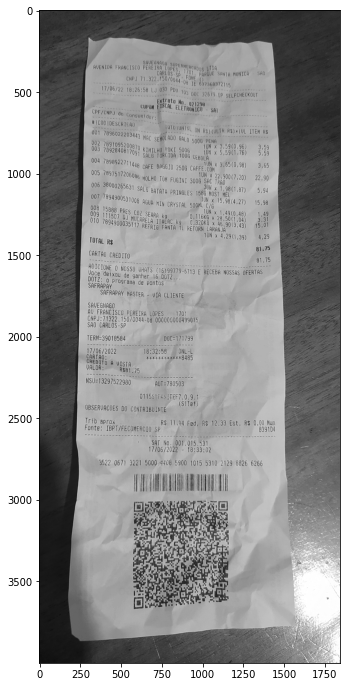

In [13]:
plt.figure(figsize=(12,12))
plt.imshow(original_img, cmap = "gray")

#### Image Process

##### 1. Performing a image thresholding using the otsu binarization method.

In [14]:
# apply otsu binarization to the pre-processed image
otsu_img: NDArray
_, otsu_img = cv2.threshold(
    clean(original_img),
    0,
    255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)

Numerical representation of image after applying the otsu method.

In [15]:
otsu_img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ..., 255,   0,   0],
       [255, 255, 255, ...,   0, 255, 255]], dtype=uint8)

Plot the image

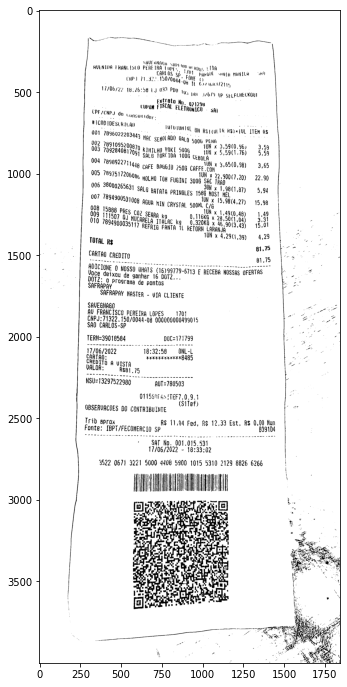

In [16]:
plt.figure(figsize=(12,12))
plt.imshow(otsu_img, cmap = "gray")

##### 2. Apply opening to the image

In [17]:
# apply morphological opening in order to close gaps
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
morph_img = cv2.morphologyEx(otsu_img, cv2.MORPH_OPEN, kernel)

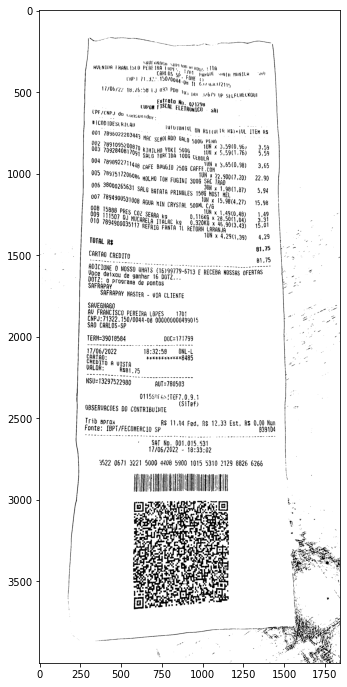

In [18]:
plt.figure(figsize=(12,12))
plt.imshow(morph_img, cmap = "gray")

The output image of opening process is not clear in the visualization of this image. To see the difference between the image pre-opening and pos-opening lets show the comparasion using cropped segments of each image (otsu_img and morph_img).

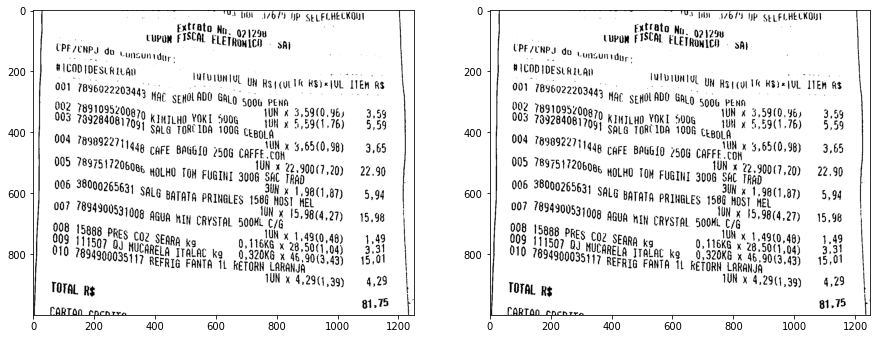

In [19]:
cropped_otsu = otsu_img[500:1500,250:1500]
cropped_morph = morph_img[500:1500,250:1500]
plt.figure(figsize=(15,15))
plt.subplot(121); plt.imshow(cropped_otsu, cmap = "gray")
plt.subplot(122); plt.imshow(cropped_morph, cmap = "gray")

##### 3. Optical Character Recognition

In [21]:
# apply OCR
text: str = pytesseract.image_to_string(
    morph_img, lang="por+grocery+eng", config="--oem 1 --psm 1"
)

In [24]:
text

'SAVE HARD Supy kin ie\nyu « TBA\nVENTION TRAN INC Pen TAN OS ge fy ul HEE MGHTLA OWN\n. yoo gt *\nCNP 1,32" 1900044" y, tt Cae anuaz2yy\n17/06/22 WW. 26:98 tJ gan Poy toy WO 47649 Wp SELFLHELKOISI\nExerBto No. 92 iz9y .\n, cupon FISCAL FLETRON{CA - 3Al\nCPF/ENP du Lunsunidur-\n#ICO ; ones\n»FBESURTL AD - MTOLUNTUL Uy Rs y cyt Te HB) TUL LITEM 8\nWe 7048922203443 Hae yo ADO FLO Soou penn 50 ar\n02 789109570087 : WN x 3,59(0,96) 3,69\n003 0 KiMTLHO VOKT 5908 §,59(1,76) 5,59\n3 7892840817945 sala taRt Iba 1008 cent a” x §,59( ) 4\n\nns TO808227 11446 cee soubs0 2506 careE yt 28098) 3.65\n00S 7897517206086, yar up TOW FUGINI 3000 Sue ikea m0\nnie 35000265631 SALG sarara paawaLes 15 Hog ig 5.98\n7834300831008 agup hIW CRYSTAL soon 15,98(4,27) 15,98\n\n| 5 en: WN\nm9 07 SE i, ko 07 300K8 B08 Hi :\nL , x 46, ‘ :\n7894909035317 REFRIG FANTA TL RETORN LaRAWR ee) 1\n\n \n\nJA a\nTWN x 4,29(1,39) 4,29 mo\nTOTAL R¢ 81.75 ,\nCARTAO CREDITO 81,75\n\nOre exes de ganhar 16\n: ogra 5\nSAFRAPEY ma de p

In [23]:
# Print output
print(Receipt(text))

RuntimeError: The receipt's products' data could not be parsed